# **Práctica modelo supervisado**


Continuamos trabjando con :
- Regresión logística
- Decision Tree

## **I. Configuración del entorno (SparkSession)**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import when, avg, max, min, round, count, col, countDistinct, expr, desc, corr

from pyspark.ml.feature import VectorAssembler, RobustScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier, plot_tree
from pyspark.mllib.evaluation import MulticlassMetrics


## **II. Carga y exploración inicial de datos**


In [3]:
spark = SparkSession.builder \
    .config("spark.driver.memory", "2g") \
    .appName("MyApp_Censo_regresion") \
    .getOrCreate()


In [4]:
#!apt-get update -y
#!apt-get install -y openjdk-17-jdk

#import os

#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
#os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

#os.environ.pop("PYSPARK_SUBMIT_ARGS", None)
#os.environ.pop("SPARK_HOME", None)

In [5]:
sdf = spark.read.csv('personas_ext_26_02.csv', header=True, inferSchema=True)

In [6]:
sdf = spark.read.csv('personas_ext_26_02.csv', header=True, inferSchema=True)

In [7]:
sdf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID_CENSO: double (nullable = true)
 |-- DIRECCION_ID: string (nullable = true)
 |-- DEPARTAMENTO: integer (nullable = true)
 |-- LOCALIDAD: integer (nullable = true)
 |-- VIVID: string (nullable = true)
 |-- HOGID: string (nullable = true)
 |-- PERID: string (nullable = true)
 |-- REGION_4: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- MUNICIPIO_PAIS: string (nullable = true)
 |-- TIPO_MUNICIPIO_PAIS: string (nullable = true)
 |-- FUENTE_EXT: integer (nullable = true)
 |-- SIT_CALLE: integer (nullable = true)
 |-- CUESTIONARIO_COMPLETO: integer (nullable = true)
 |-- CUESTIONARIO_BASICO: integer (nullable = true)
 |-- RRAA: integer (nullable = true)
 |-- UNIVERSO: integer (nullable = true)
 |-- VIVVO00: integer (nullable = true)
 |-- PERPH02: integer (nullable = true)
 |-- PERNA01: integer (nullable = true)
 |-- PERNA01_TRAMO: string (nullable = true)
 |-- PERPA01: integer (nullable = true)
 |-- PERPA02: integer (nulla

In [8]:
sdf.show(5)

+---+--------+------------+------------+---------+-----+-----+-----+--------+----+--------------+-------------------+----------+---------+---------------------+-------------------+----+--------+-------+-------+-------+-------------+-------+-------+---------+-------+---------+---------+---------+---------+---------+---------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+---------+---------+-------+-------+---------+-------+---------+---------+-------+---------+---------+-------+-------+-------+-------+-------+---------+---------+-------+---------+-------+-------+---------+-----------+---------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+-------+--------+--------+------------------------+-----------+----------+---------------+----------+---------------+------------+-----------------+-------+------------+
|_c

## **III. Análisis descriptivo y preprocesamiento de los datos**

In [9]:
sdf_small = sdf.select(["PERAL01", "PERNA01", "PERPH02", "PERED03"])

In [10]:
sdf_small.show(3)

+-------+-------+-------+-------+
|PERAL01|PERNA01|PERPH02|PERED03|
+-------+-------+-------+-------+
|   8888|     74|      2|   8888|
|   8888|     37|      1|   8888|
|   8888|     39|      2|   8888|
+-------+-------+-------+-------+
only showing top 3 rows



In [11]:
sdf_clean = (sdf_small
    .withColumnRenamed("PERAL01", "trabaja")
    .withColumnRenamed("PERPH02", "sexo")
    .withColumnRenamed("PERNA01", "edad")
    .withColumnRenamed("PERED03", "educacion")
)

In [12]:
sdf_clean.describe().show()


+-------+------------------+------------------+-------------------+-----------------+
|summary|           trabaja|              edad|               sexo|        educacion|
+-------+------------------+------------------+-------------------+-----------------+
|  count|           3499451|           3499451|            3499451|          3499451|
|   mean|2049.3241034093635|1007.2870181637062| 1.5157874763784376| 6126.51568746069|
| stddev|3604.4598443918403| 2099.288864007407|0.49975076484000824|3376.671568065082|
|    min|                 1|                 0|                  1|                1|
|    max|              9898|              5555|                  2|             9898|
+-------+------------------+------------------+-------------------+-----------------+



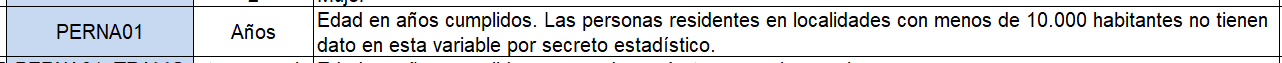

In [13]:
sdf_clean = sdf_clean.withColumn(
    "edad",
    F.when((F.col("edad") >= 0) & (F.col("edad") <= 100), F.col("edad")).otherwise(None)
)

In [14]:
sdf_clean.select("edad").describe().show()


+-------+------------------+
|summary|              edad|
+-------+------------------+
|  count|           2884421|
|   mean|38.312764676168975|
| stddev|22.923934241759472|
|    min|                 0|
|    max|               100|
+-------+------------------+



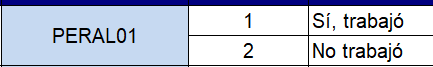

In [15]:
sdf_clean = sdf_clean.withColumn(
    "trabaja",
    F.when(F.col("trabaja") == 1, 1)
     .when(F.col("trabaja") == 2, 0)
     .otherwise(None)
)


In [16]:
sdf_clean.select("trabaja").describe().show()


+-------+-------------------+
|summary|            trabaja|
+-------+-------------------+
|  count|            2641252|
|   mean| 0.5211505755603781|
| stddev|0.49955254742240285|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



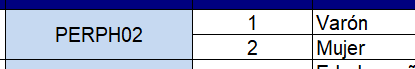

In [17]:
sdf_clean = sdf_clean.withColumn(
    "sexo",
    F.when(F.col("sexo").isin(1, 2),
    F.col("sexo")).otherwise(None)
)

In [18]:
sdf_clean.select("sexo").describe().show()


+-------+-------------------+
|summary|               sexo|
+-------+-------------------+
|  count|            3499451|
|   mean| 1.5157874763784376|
| stddev|0.49975076484000824|
|    min|                  1|
|    max|                  2|
+-------+-------------------+



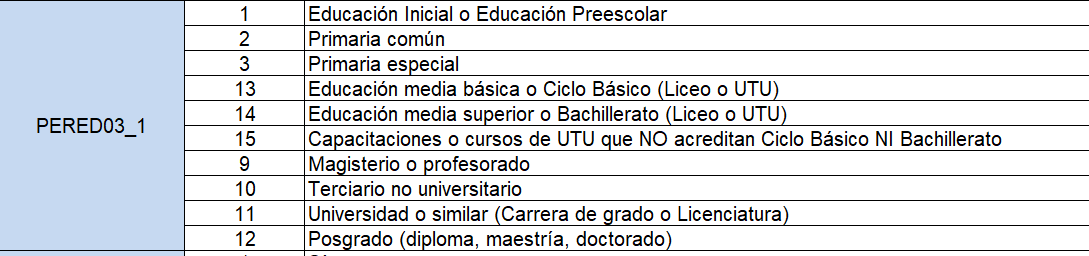

In [19]:
sdf_clean = sdf_clean.withColumn(
    "educacion",
    F.when((F.col("educacion") >= 1) & (F.col("educacion") <= 20), F.col("educacion")).otherwise(None)
)


In [20]:
sdf_clean.select("educacion").describe().show()


+-------+-----------------+
|summary|        educacion|
+-------+-----------------+
|  count|           808909|
|   mean|8.107318622984785|
| stddev|5.359027447966297|
|    min|                1|
|    max|               15|
+-------+-----------------+



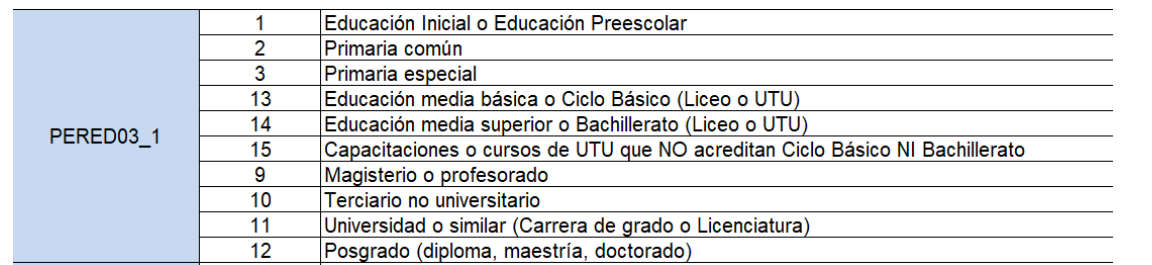

Aseguramos que 'educacion' sea entero

In [21]:
sdf_clean = sdf_clean.withColumn("educacion", F.col("educacion").cast("int"))

Clasificación A (estricta por nivel oficial)

      1 = Inicial

      2 = Primaria común

      3 = Primaria especial

      15 = Cursos UTU no acreditados (debajo de CB)

      13 = Ciclo Básico

      14 = Bachillerato

      9 = Magisterio/Profesorado

      10 = Terciario no universitario

      11 = Universidad

      12 = Posgrado


In [22]:
sdf_clean = sdf_clean.withColumn(
    "educacion_orden",
    F.when(F.col("educacion") == 1,  1) \
     .when(F.col("educacion") == 2,  2) \
     .when(F.col("educacion") == 3,  3) \
     .when(F.col("educacion") == 15, 4) \
     .when(F.col("educacion") == 13, 5) \
     .when(F.col("educacion") == 14, 6) \
     .when(F.col("educacion") == 9,  7) \
     .when(F.col("educacion") == 10, 8) \
     .when(F.col("educacion") == 11, 9) \
     .when(F.col("educacion") == 12, 10) \
     .otherwise(None)
)


In [23]:
sdf_clean.describe().show()

+-------+-------------------+------------------+-------------------+-----------------+------------------+
|summary|            trabaja|              edad|               sexo|        educacion|   educacion_orden|
+-------+-------------------+------------------+-------------------+-----------------+------------------+
|  count|            2641252|           2884421|            3499451|           808909|            808909|
|   mean| 0.5211505755603781|38.312764676168975| 1.5157874763784376|8.107318622984785|4.6827986831646085|
| stddev|0.49955254742240285|22.923934241759472|0.49975076484000824|5.359027447966297|2.7377092032703207|
|    min|                  0|                 0|                  1|                1|                 1|
|    max|                  1|               100|                  2|               15|                10|
+-------+-------------------+------------------+-------------------+-----------------+------------------+



Quitar solo las filas con null

In [24]:

sdf_clean = sdf_clean.dropna(subset=["trabaja","edad","sexo","educacion_orden"])

In [25]:
sdf_clean.describe().show()

+-------+------------------+------------------+-------------------+------------------+-----------------+
|summary|           trabaja|              edad|               sexo|         educacion|  educacion_orden|
+-------+------------------+------------------+-------------------+------------------+-----------------+
|  count|            431315|            431315|             431315|            431315|           431315|
|   mean|0.3053754216755735| 22.22648180564089| 1.5490604314711987|11.858592907735646|6.482603201836245|
| stddev|0.4605667870292752|10.650285721995893|0.49758782954121217|2.7325263868756653|1.971456295785069|
|    min|                 0|                12|                  1|                 2|                2|
|    max|                 1|                78|                  2|                15|               10|
+-------+------------------+------------------+-------------------+------------------+-----------------+



## **IV. Regresión logística**

1. Seleccionar columnas

In [26]:
cols = ["trabaja", "edad", "sexo", "educacion_orden"]
sdf_model = sdf_clean.select(cols)

2. Preparar train/test split

In [27]:
assembler = VectorAssembler(
    inputCols=["edad", "sexo", "educacion_orden"],
    outputCol="features"
)

sdf2 = assembler.transform(sdf_model)


Ahora hacemos el split:

In [28]:
train, test = sdf2.randomSplit([0.8, 0.2], seed=42)


3. Entrenar la regresión logística

In [29]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="trabaja"
)

model_simple = lr.fit(train)

4. Predecir

In [30]:
pred_simple = model_simple.transform(test)

pred_simple.select("trabaja", "prediction", "probability").show(10, truncate=False)


+-------+----------+-----------------------------------------+
|trabaja|prediction|probability                              |
+-------+----------+-----------------------------------------+
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
|0      |0.0       |[0.9897155446358137,0.010284455364186318]|
+-------+----------+-----------------------------------------+
only showing top 10 rows



In [31]:
lr_simple = lr.fit(train)

pred_test = lr_simple.transform(test)

acc_eval = MulticlassClassificationEvaluator(
    labelCol="trabaja",
    predictionCol="prediction",
    metricName="accuracy"
)

acc_simple = acc_eval.evaluate(pred_test)
print(f"Accuracy del modelo simple: {acc_simple:.3f}")


Accuracy del modelo simple: 0.834


5. Matriz de confusión

| Tipo de resultado | Qué significa | Ejemplo sencillo |
|--------------------|----------------|------------------|
| **Verdadero Positivo (TP)** | El modelo predijo **“sí trabaja”** y la persona **realmente trabaja.**. | El modelo dice que trabaja → y efectivamente trabaja.  **COUNT: 16 937**|
| **Verdadero Negativo (TN)** | El modelo predijo **“no trabaja”** y la persona **realmente no trabaja**. | El modelo dice que no trabaja → y efectivamente no trabaja. **COUNT: 54802** |
| **Falso Positivo (FP)** | El modelo predijo **“sí trabaja”**, pero la persona **en realidad no trabaja**. | El modelo se confunde y cree que trabaja cuando no es así.  **COUNT: 4 998**|
| **Falso Negativo (FN)** | El modelo predijo **“no trabaja”**, pero la persona **sí trabaja**. | El modelo no detectó a alguien que realmente trabaja.   **COUNT: 9 268**|


In [32]:
pred_test.groupBy("trabaja", "prediction").count().show()

+-------+----------+-----+
|trabaja|prediction|count|
+-------+----------+-----+
|      1|       0.0| 9268|
|      0|       0.0|54802|
|      1|       1.0|16937|
|      0|       1.0| 4998|
+-------+----------+-----+



6. Grid search

In [33]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.1, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

7. Cross validation

In [34]:
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=acc_eval,
    numFolds=3
)

In [35]:
cv_model = cv.fit(train)
pred_cv = cv_model.transform(test)
accuracy_cv = acc_eval.evaluate(pred_cv)
print("Accuracy con CV:", accuracy_cv)


Accuracy con CV: 0.8341259229114586


Accuracy del modelo simple: 0.834

In [36]:
df_results = pd.DataFrame({
    "Modelo": ["Simple", "CV + GridSearch"],
    "Accuracy": [acc_simple, accuracy_cv]
})

df_results


Modelo  Accuracy
0           Simple  0.834126
1  CV + GridSearch  0.834126

ENTRENAR Y EVALUAR (PySpark)

In [37]:
dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="trabaja",
    maxDepth=4,
    seed=42
)

dt_model = dt.fit(train)

pred_dt = dt_model.transform(test)

pred_dt.select("trabaja", "prediction", "probability").show(10, truncate=False)

acc_eval = MulticlassClassificationEvaluator(
    labelCol="trabaja",
    predictionCol="prediction",
    metricName="accuracy"
)

acc_dt = acc_eval.evaluate(pred_dt)
print(f"Accuracy del Árbol de Decisión: {acc_dt:.3f}")


+-------+----------+---------------------------------------+
|trabaja|prediction|probability                            |
+-------+----------+---------------------------------------+
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
|0      |0.0       |[0.932379431904173,0.06762056809582695]|
+-------+----------+---------------------------------------+
only showing top 10 rows

Accuracy del Árbol de Decisión: 0.851


In [38]:
print(dt_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_bf9b059c5b17, depth=4, numNodes=13, numClasses=2, numFeatures=3
  If (feature 0 <= 21.5)
   Predict: 0.0
  Else (feature 0 > 21.5)
   If (feature 0 <= 24.5)
    If (feature 0 <= 22.5)
     Predict: 0.0
    Else (feature 0 > 22.5)
     If (feature 2 <= 3.5)
      Predict: 0.0
     Else (feature 2 > 3.5)
      Predict: 1.0
   Else (feature 0 > 24.5)
    If (feature 2 <= 5.5)
     If (feature 2 <= 3.5)
      Predict: 0.0
     Else (feature 2 > 3.5)
      Predict: 1.0
    Else (feature 2 > 5.5)
     Predict: 1.0



### **OPCIÓN VISUAL**

Extraer datos de entrenamiento a pandas

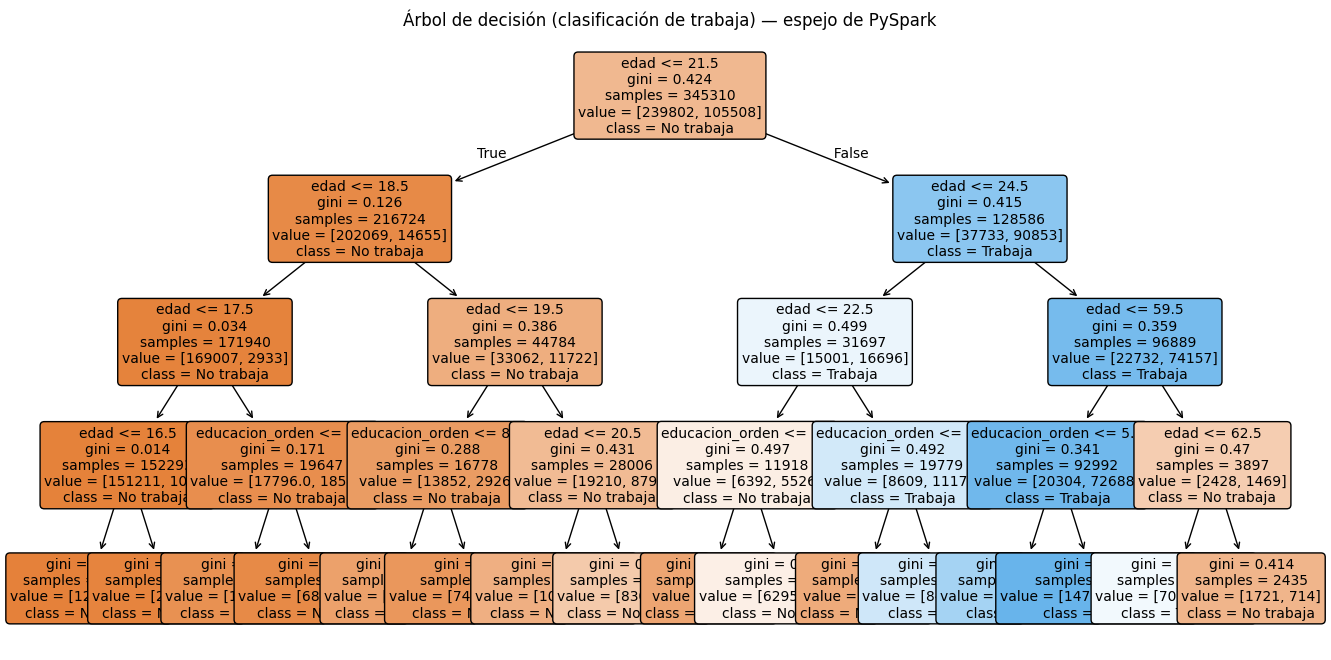

In [39]:
train_pd = train.select("features", "trabaja").toPandas()
X = np.array([list(v) for v in train_pd["features"]])
y = train_pd["trabaja"].to_numpy().astype(int)

from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
    splitter="best",
    random_state=42
)
clf.fit(X, y)

plt.figure(figsize=(16, 8))
plot_tree(
    clf,
    filled=True,
    feature_names=["edad", "sexo", "educacion_orden"] if X.shape[1]==3 else None,
    class_names=["No trabaja", "Trabaja"],
    rounded=True,
    fontsize=10
)
plt.title("Árbol de decisión (clasificación de trabaja) — espejo de PySpark")
plt.show()


Optimizar la visualización del gráfico anterior. (El objetivo es presentar los mismos resultados de manera más efectiva).

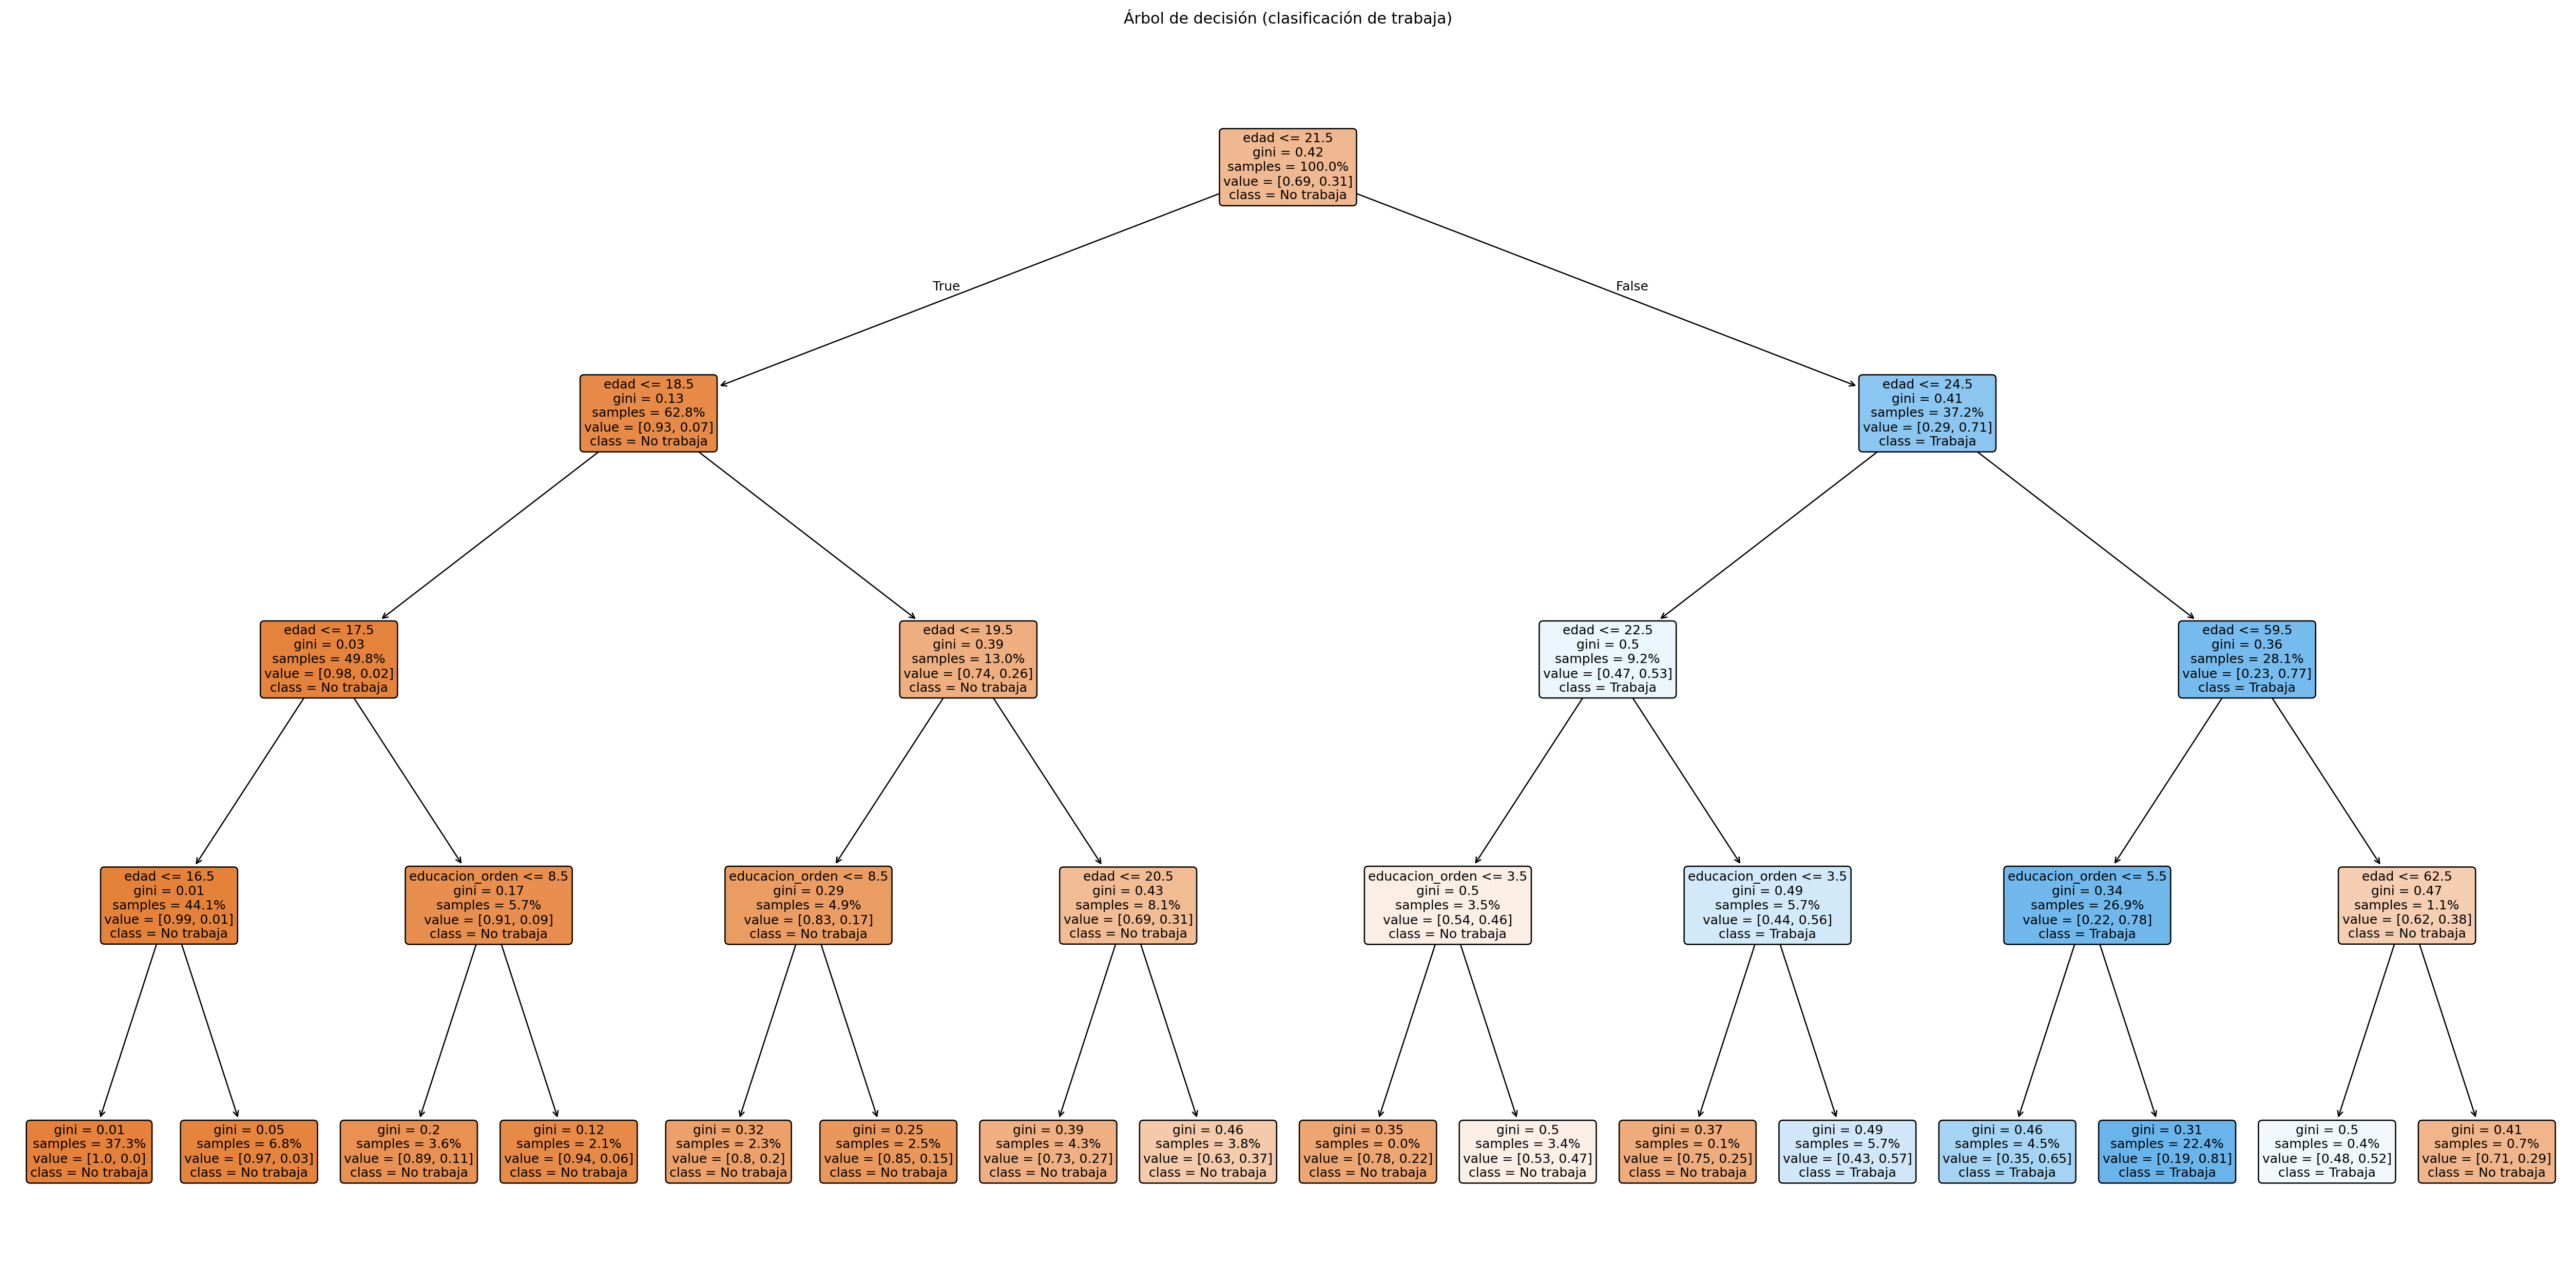

<Figure size 640x480 with 0 Axes>

In [40]:
plt.figure(figsize=(28, 14), dpi=180)
plot_tree(
    clf,
    feature_names=["edad", "sexo", "educacion_orden"] if X.shape[1]==3 else None,
    class_names=["No trabaja", "Trabaja"],
    filled=True,
    rounded=True,
    proportion=True,
    precision=2,
    fontsize=10)

plt.title("Árbol de decisión (clasificación de trabaja)", pad=16)
plt.margins(x=0.02, y=0.05)
plt.tight_layout()
plt.show()

plt.savefig("arbol_trabaja.png", bbox_inches="tight", pad_inches=0.4, dpi=300)

En este gráfico se muestra un árbol de decisión entrenado con los siguientes parámetros:

- **criterion="gini"** → utiliza el índice de Gini para medir la pureza de los nodos (métrica por defecto en PySpark y scikit-learn).

- **max_depth=8 →** permite que el árbol crezca hasta 8 niveles, otorgándole mayor capacidad para capturar relaciones complejas en los datos, aunque controlado por otros parámetros para evitar sobreajuste.

- **splitter="random"** → en lugar de buscar siempre el mejor punto de corte, selecciona aleatoriamente entre los candidatos. Esto introduce variabilidad y puede generar árboles más diversos y generalizables.

- **min_samples_leaf=8** → obliga a que cada hoja contenga al menos 8 observaciones. Esto suaviza el modelo y evita divisiones basadas en muy pocos datos, reduciendo el sobreajuste.

- **random_state=42** → asegura la reproducibilidad de los resultados.

La combinación de una mayor profundidad con restricciones en el tamaño mínimo de las hojas y divisiones aleatorias permite un árbol más expresivo pero menos propenso al sobreajuste, equilibrando complejidad y robustez.

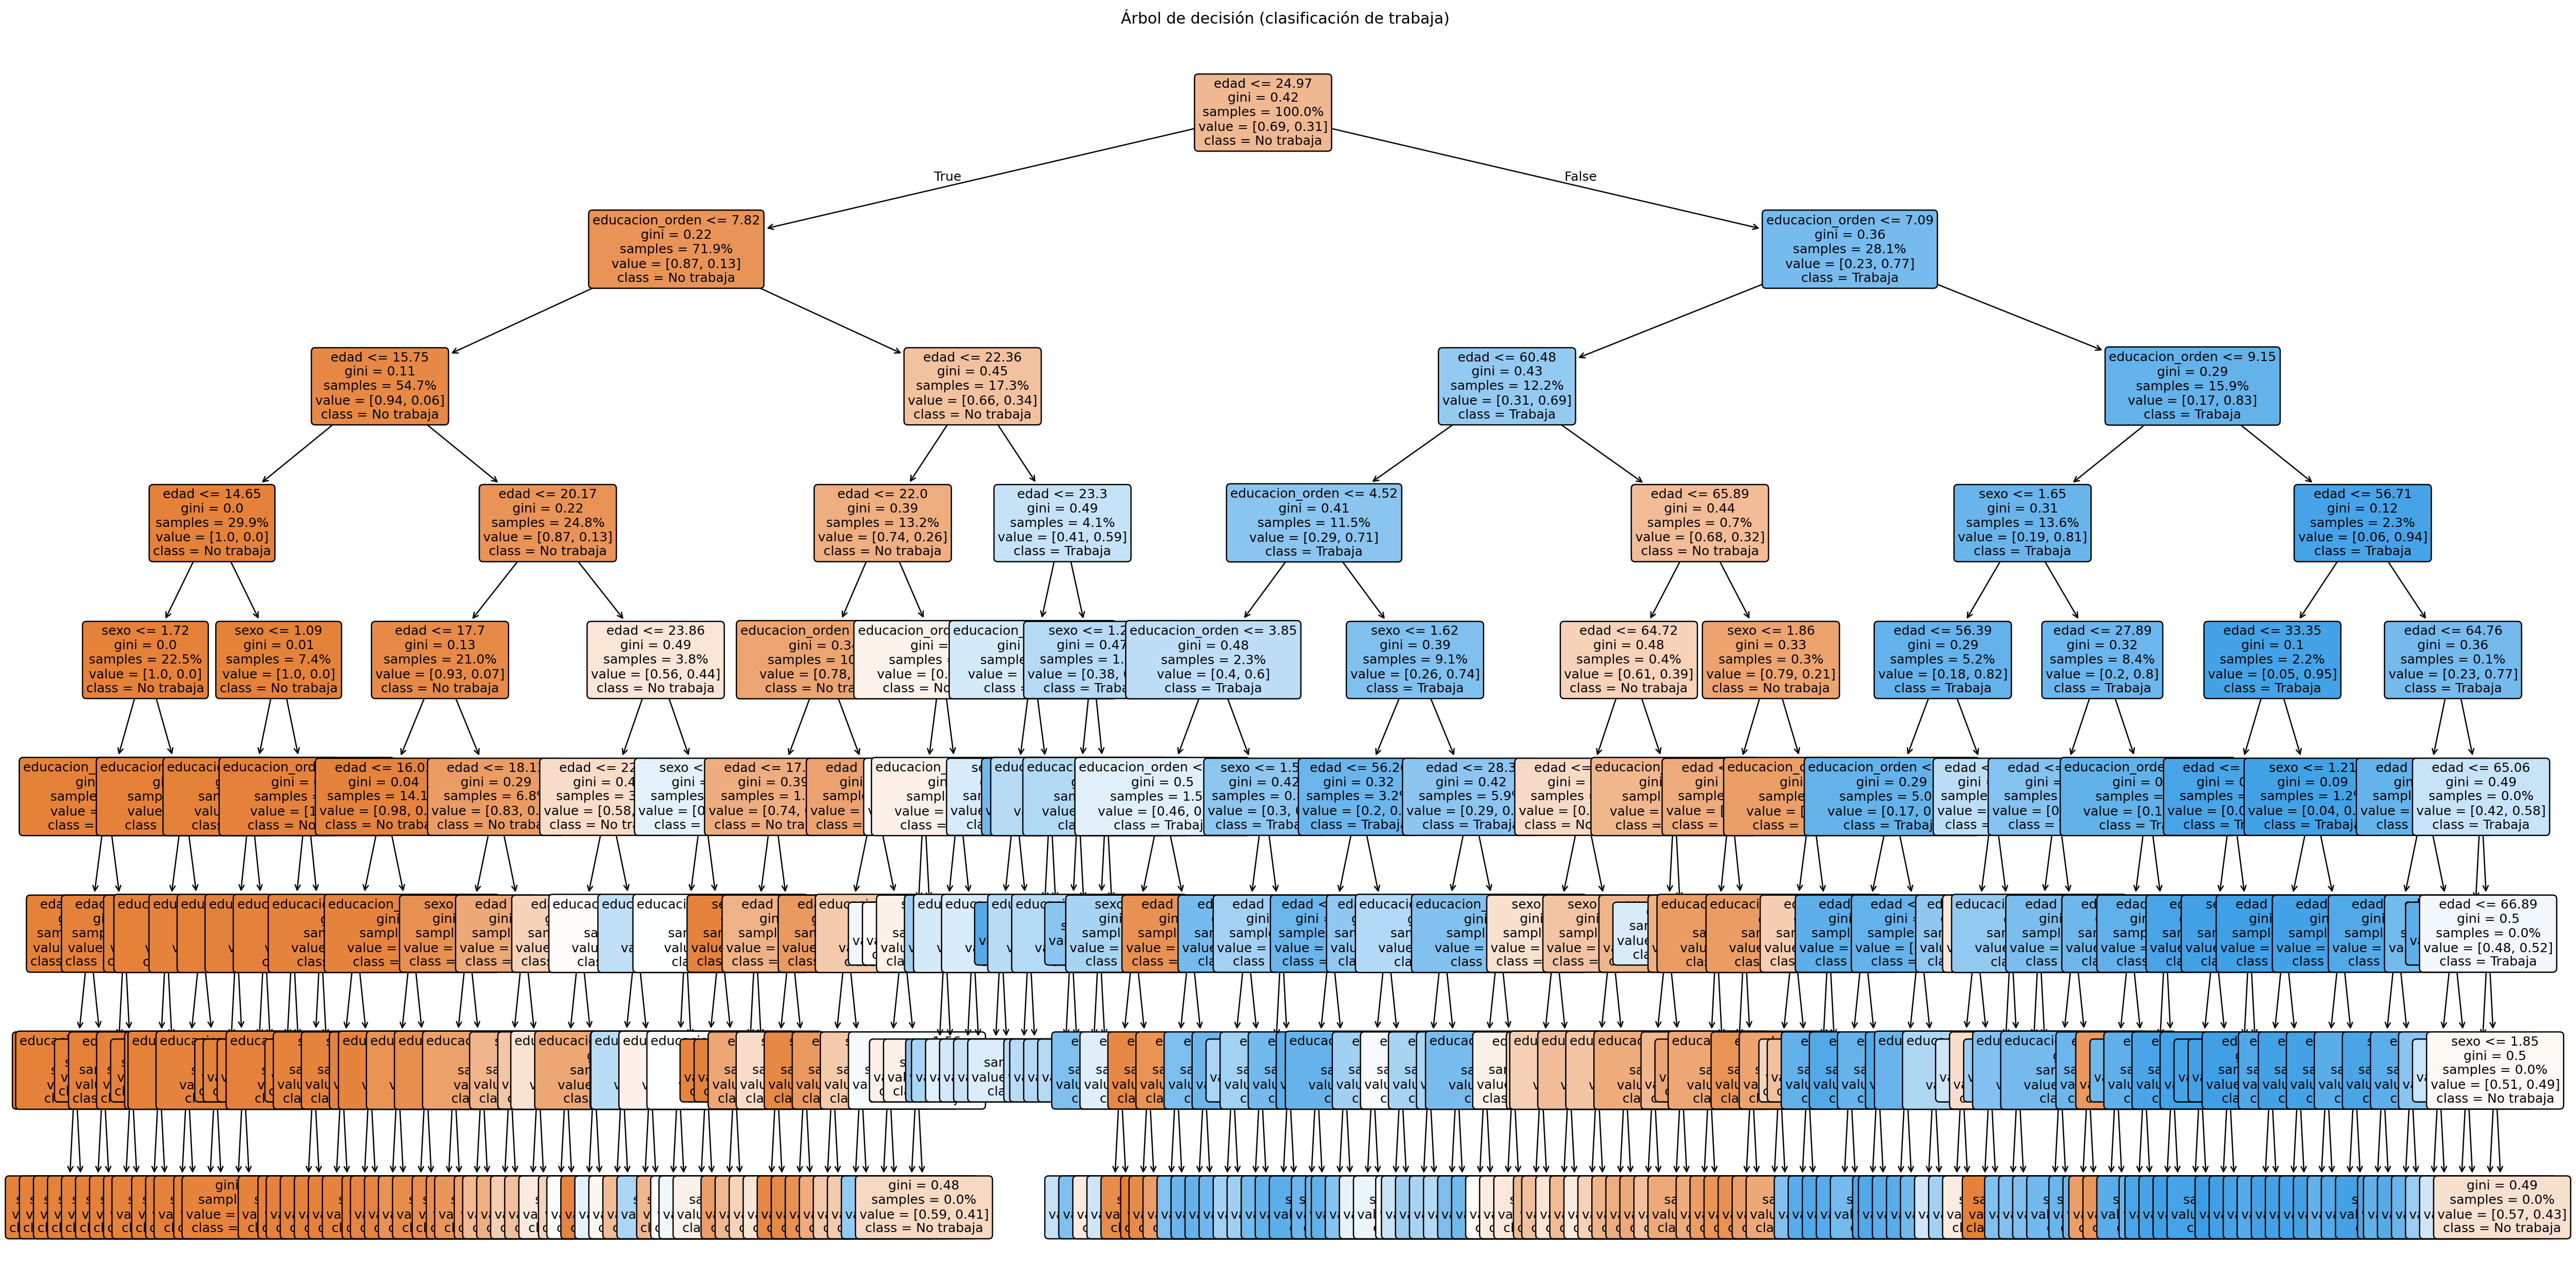

<Figure size 640x480 with 0 Axes>

In [45]:
dt2 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=8,
    splitter="random",
    min_samples_leaf=8,
    random_state=42)

dt2.fit(X, y)

plt.figure(figsize=(28, 14), dpi=180)
plot_tree(
    dt2,
    feature_names=["edad", "sexo", "educacion_orden"] if X.shape[1]==3 else None,
    class_names=["No trabaja", "Trabaja"],
    filled=True,
    rounded=True,
    proportion=True,
    precision=2,
    fontsize=10)

plt.title("Árbol de decisión (clasificación de trabaja)", pad=16)
plt.margins(x=0.02, y=0.05)
plt.tight_layout()
plt.show()

plt.savefig("arbol_trabaja.png", bbox_inches="tight", pad_inches=0.4, dpi=300)

In [48]:
spark.stop()

| Parámetro (PySpark) | Qué controla | Valores típicos a probar | Qué cambia al moverlo (implicaciones) |
|----------------------|---------------|---------------------------|---------------------------------------|
| **impurity** | Criterio para medir la calidad del split | `"gini"`, `"entropy"` | Controla cómo se mide la pureza de los nodos. *Entropy* tiende a divisiones más informativas pero algo más lentas; *gini* suele ser más rápido y da resultados similares. |
| **maxDepth** | Profundidad máxima del árbol | 2, 4, 6, 8, 10 | Limita los niveles de decisión desde la raíz. Profundidad baja → modelo más simple, menos overfitting. Profundidad alta → mayor ajuste, pero riesgo de sobreajuste. |
| **minInstancesPerNode** | Mínimo de instancias requeridas en un nodo para dividirlo | 1, 2, 5, 10 | Si un nodo tiene menos instancias que este valor, no se divide. Valores altos → árbol más general. Valores bajos → árbol más detallado. |
| **minInfoGain** | Ganancia mínima de información requerida para dividir un nodo | 0.0, 0.001, 0.01 | Evita divisiones con poca mejora. Útil para controlar el crecimiento del árbol y evitar sobreajuste. |
| **maxBins** | Número de bins para discretizar variables continuas | 32, 64, 128 | Afecta la precisión de los puntos de corte en variables numéricas. Mayor número → divisiones más precisas, pero mayor coste computacional. |
| **maxMemoryInMB** | Memoria máxima usada durante el entrenamiento | 128, 256, 512 | Puede ajustarse en datasets grandes para evitar errores de memoria en nodos del cluster. |
| **weightCol** | Columna con pesos de instancia (para clases desbalanceadas) | nombre de columna o `None` | Permite ponderar ejemplos o clases. Simula el efecto de `class_weight` de scikit-learn. |


### Notas clave
- PySpark **no incluye** directamente parámetros como `min_samples_leaf`, `max_features`, `max_leaf_nodes`, `splitter` o `ccp_alpha` (poda post-entrenamiento).  
  > Estos se pueden explorar en **scikit-learn**, donde hay más control fino sobre la estructura y la poda del árbol.  
- **`maxDepth`**, `minInstancesPerNode` y `minInfoGain` son los más comunes para regular la complejidad del modelo en PySpark.  
- **`impurity`** (equivalente a `criterion` en scikit-learn) afecta la métrica usada para decidir los splits.  
- **`maxBins`** es relevante cuando hay variables numéricas continuas o muchas categorías en variables categóricas codificadas.



Referencia: [How to tune a Decision Tree in Hyperparameter tuning](https://www.geeksforgeeks.org/machine-learning/how-to-tune-a-decision-tree-in-hyperparameter-tuning/)

**Enlaces de referencia para el tratamiento de datos:**

[6 formas diferentes de compensar la falta de datos (imputación de datos con ejemplos)](https://ichi.pro/es/6-formas-diferentes-de-compensar-la-falta-de-datos-imputacion-de-datos-con-ejemplos-105702799050617)

[Tratamiento de valores faltantes
](https://datos.ninja/tutorial/tratamiento-de-valores-faltantes/)

[Introduction to Data Imputation](https://www.analyticsvidhya.com/blog/2021/06/defining-analysing-and-implementing-imputation-techniques/)

[Data Imputation: A Comprehensive Guide to Handling Missing Values](https://medium.com/%40ajayverma23/data-imputation-a-comprehensive-guide-to-handling-missing-values-b5c7d11c3488)

[Top 4 Techniques for Handling Missing Values in Machine Learning](https://blog.paperspace.com/top-4-techniques-for-handling-the-missing-values-in-machine-learning/)

**Enlaces de regerencias para el árbol de decisión**


[How to tune a Decision Tree in Hyperparameter tuning](https://www.geeksforgeeks.org/machine-learning/how-to-tune-a-decision-tree-in-hyperparameter-tuning/)


[Decision Trees: Split Methods & Hyperparameter Tuning](https://www.analyticsvidhya.com/blog/2024/03/decision-trees-split-methods-hyperparameter-tuning/)